In [139]:
import random

import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch.nn import *
from torch.optim import *

from model import LSTMModel

Read Preprocessed Dataset 

In [140]:
path = './data/final_data.csv'
df = pd.read_csv(path)
# select relevant features
# moods = df[['mood', 'ID']]
moods = df[['mood', 'ID', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.social', 'appCat.utilities', 'appCat.weather', 'time']]
# process id and mood
moods['time'] = pd.to_datetime(moods['time'])
moods['time'] = moods['time'].dt.weekday

moods['ID'] = (moods['ID'] - 14) * 100
moods['ID'] = moods['ID'].astype(int)
# moods = pd.get_dummies(moods, columns=['ID'])
moods['mood'] = moods['mood'].apply(lambda x: 0 if x <= 4 else (1 if 5 <= x <= 7 else 2))
# moods['mood'] = moods['mood'].round().astype(int)
print(moods['mood'].value_counts())
print(moods)

mood
1    707
2    554
0      7
Name: count, dtype: int64
      mood  ID  circumplex.arousal  circumplex.valence  activity    screen  \
0        1   0           -0.220617            0.145647 -0.650267 -0.652424   
1        1   0            0.156768           -0.813869 -0.838609 -0.715377   
2        1   0            0.458676           -1.120914  0.194961  2.619738   
3        1   0            1.062492           -0.430063  1.290503  0.057883   
4        1   0            0.458676            0.260788  0.287554  0.194597   
...    ...  ..                 ...                 ...       ...       ...   
1263     1  33           -0.748957           -0.660346 -1.097846 -0.386298   
1264     2  33            0.156768            1.181923 -0.132635  1.828020   
1265     1  33           -1.855953            0.721356  0.571090 -0.498959   
1266     1  33           -1.050865           -2.502616  0.821955  0.784119   
1267     1  33           -2.862313            0.721356  0.080015  0.011292   

     

C:\Users\china\AppData\Local\Temp\ipykernel_4832\3465200166.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moods['time'] = pd.to_datetime(moods['time'])
C:\Users\china\AppData\Local\Temp\ipykernel_4832\3465200166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moods['time'] = moods['time'].dt.weekday
C:\Users\china\AppData\Local\Temp\ipykernel_4832\3465200166.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [141]:
random.seed(42)
# define hyper-parameters
hidden_size = 64 # 隐藏层维度
num_layers = 1  # LSTM层数
output_size = 3  # 输出维度
num_epochs = 500  # 迭代次数
learning_rate = 1e-3  # 学习率
max_grad_norm = 10.0

seq_length = 14
batch_size = 32
step = 1
# generate dataset
ids = moods['ID'].unique()
id_moods = []
for uid in ids:
    # uid = uid
    id_mood = moods[moods['ID'] == uid]
    id_moods.append(id_mood)
# remove data that is not continuous
id_moods[0] = id_moods[0][2:]

dataset = []
for id_mood in id_moods:
    id_dataset = [id_mood[i:i + seq_length + 1] for i in range(0, len(id_mood) - seq_length, step)]
    id_dataset = [df.to_numpy() for df in id_dataset]
    dataset += id_dataset

print('dataset size:', len(dataset))
# split it into train set and test set.
random_indices = random.sample(range(len(dataset)), k=int(len(dataset) / 5))
train_set = []
test_set = []

for i in range(len(dataset)):
    if i in random_indices:
        test_set.append(dataset[i])
    else:
        train_set.append(dataset[i])
print('train set size:',len(train_set))
print('test set size:', len(test_set))

random.shuffle(train_set)
random.shuffle(test_set)
X_train = [element[:seq_length] for element in train_set]
y_train = [element[seq_length:][0][:1] for element in train_set]
X_test = [element[:seq_length] for element in test_set]
y_test = [element[seq_length:][0][:1] for element in test_set]

# convert them into Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset size: 930
train set size: 744
test set size: 186


In [142]:
# 定义参数
input_size = X_train.shape[-1]  # 输入维度
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 创建模型并将其移动到设备上
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
# 定义损失函数和优化器
criterion = CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=learning_rate)
optimizer = RMSprop(model.parameters(), lr=learning_rate)

loss_history = []
test_acc_history = []
train_acc_history = []
batch_num = len(X_train) // batch_size
# 训练模型
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size].to(device)
        targets = y_train[i:i + batch_size].to(device)
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        total_loss += loss.item()
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        # 剪枝
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        
    total_loss = total_loss / batch_num
    loss_history.append(total_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}')
        # 模型评估
        with torch.no_grad():
            correct = 0
            total = 0
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i + batch_size].to(device)
                targets = y_test[i:i + batch_size].to(device)
                targets = targets.transpose(0, 1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(1)
                correct_matrix = (predicted == targets)
                correct += (predicted == targets).sum().item()
            print(f'Accuracy on test set: {100 * correct / total:.2f}%')
            test_acc_history.append(100 * correct / total)

            correct = 0
            total = 0
            for i in range(0, len(X_train), batch_size):
                inputs = X_train[i:i + batch_size].to(device)
                targets = y_train[i:i + batch_size].to(device)
                targets = targets.transpose(0, 1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                # print(predicted)
                # print(targets)
                total += targets.size(1)
                correct_matrix = (predicted == targets)
                correct += (predicted == targets).sum().item()
            print(f'Accuracy on train set: {100 * correct / total:.2f}%')
            train_acc_history.append(100 * correct / total)
    

Epoch [10/500], Loss: 0.6344
Accuracy on test set: 68.82%
Accuracy on train set: 66.94%
Epoch [20/500], Loss: 0.5794
Accuracy on test set: 67.74%
Accuracy on train set: 70.70%
Epoch [30/500], Loss: 0.5210
Accuracy on test set: 72.58%
Accuracy on train set: 75.54%
Epoch [40/500], Loss: 0.4762
Accuracy on test set: 69.89%
Accuracy on train set: 79.30%
Epoch [50/500], Loss: 0.4110
Accuracy on test set: 70.97%
Accuracy on train set: 81.45%
Epoch [60/500], Loss: 0.3533
Accuracy on test set: 69.89%
Accuracy on train set: 86.69%
Epoch [70/500], Loss: 0.3052
Accuracy on test set: 69.35%
Accuracy on train set: 86.83%
Epoch [80/500], Loss: 0.2510
Accuracy on test set: 68.82%
Accuracy on train set: 91.67%
Epoch [90/500], Loss: 0.2000
Accuracy on test set: 68.82%
Accuracy on train set: 90.59%
Epoch [100/500], Loss: 0.1632
Accuracy on test set: 70.97%
Accuracy on train set: 93.41%
Epoch [110/500], Loss: 0.1320
Accuracy on test set: 67.74%
Accuracy on train set: 92.61%
Epoch [120/500], Loss: 0.1050


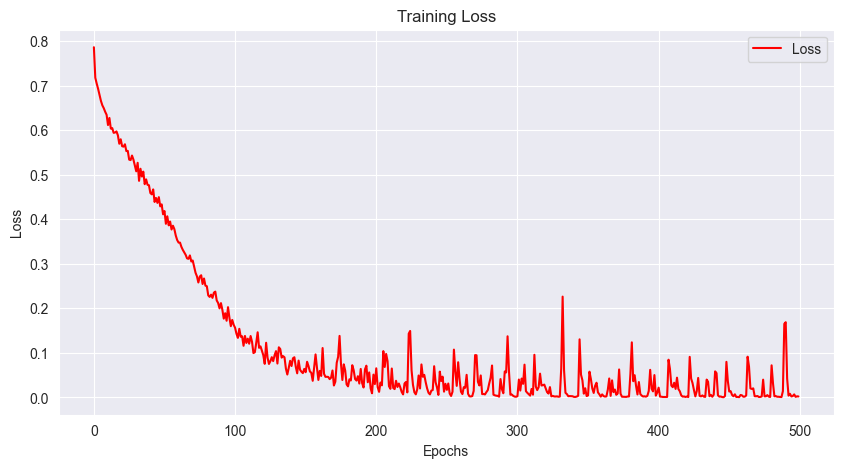

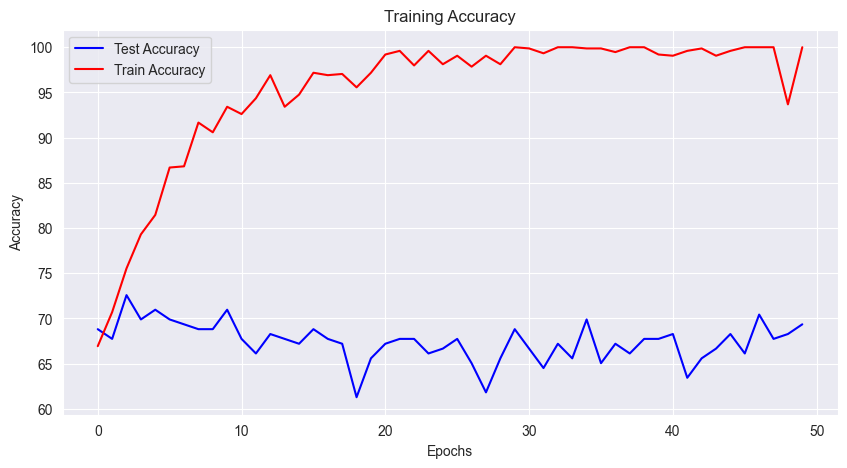

In [143]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'r', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 绘制准确率图像
plt.figure(figsize=(10, 5))
plt.plot(test_acc_history, 'b', label='Test Accuracy')
plt.plot(train_acc_history, 'r', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()